<a href="https://colab.research.google.com/github/OxanaMakhneva/Anomaly/blob/master/anomaly_detectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=06346bc88882c02a8c7b9718bd015de07cdccdbe22f2afc27c47cc961a5df238
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [4]:
import pandas as pd
from pathlib import Path
import shutil
import numpy as np
from numpy import percentile
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use({'figure.facecolor':'white'})
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.api import ExponentialSmoothing

from pyod.models.pca import PCA as pyod_PCA
from pyod.models.mcd import MCD as pyod_MCD
from pyod.models.hbos import HBOS as pyod_HBOS
from pyod.models.abod import ABOD as pyod_ABOD
from pyod.models.lof import LOF as pyod_LOF
from pyod.models.cblof import CBLOF as pyod_CBLOF
from pyod.models.iforest import IForest as pyod_IF
from pyod.models.knn import KNN as pyod_KNN
from pyod.models.lscp import LSCP as pyod_LSCP

In [5]:
file_obj = Path('distribution_anomaly_detectors.py')
if not file_obj.is_file():
  shutil.copy(Path('/content/drive/MyDrive/DF/distribution_anomaly_detectors.py'), file_obj)
else:
  file_obj.unlink()
  shutil.copy(Path('/content/drive/MyDrive/DF/distribution_anomaly_detectors.py'), file_obj)

from distribution_anomaly_detectors import OutlierDetector, MeanAnomalyDetector, DistributionBasedAnomalyDetector, RareDistributionDetector

In [6]:
def show_plots(df, columns, anomaly_column=None):
    fig, axs = plt.subplots(len(columns), 1, sharex=True, constrained_layout=True, figsize=(5,9))
    for i in range(len(columns)):
        c = columns[i]

        axs[i].plot(dd.index, df[c], color='gray',label='Normal')

        if anomaly_column:
            a = df.loc[df[anomaly_column] == 1, [c]] #anomaly
            axs[i].scatter(a.index, a[c], color='red', label='Anomaly')

        axs[i].xaxis_date()
        axs[i].set_title(c)
        plt.xlabel('Date')
    plt.show()

In [7]:
df = pd.read_csv(Path('/content/drive/MyDrive/DF/dataset.csv'), encoding = 'cp1255')
df['datetime'] = pd.to_datetime(df.datetime, format = '%Y-%m-%d %H:%M:%S', errors='coerce')

ou = 471
column = 'cheques'

dd = df.query('ou == @ou')
dd = dd.set_index('datetime')
dd = dd[[column]].resample('D').sum()
dd = dd[:-5]

dd['lag'] = dd[column].shift(periods=1)
dd['lag_7'] = dd[column].shift(periods=7)
dd.dropna(inplace=True)

**Кластеризация KMEANS** (несколько признаков)

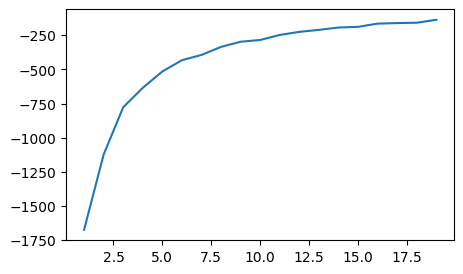

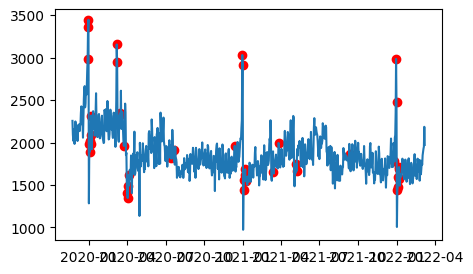

In [25]:
#Данные
dd = df.query('ou == @ou')
dd = dd.set_index('datetime')
dd = dd[[column]].resample('D').sum()
dd = dd[:-5]
dd['lag'] = dd[column].shift(periods=1)
dd['lag_7'] = dd[column].shift(periods=7)
dd.dropna(inplace=True)

#Нужное число конпонент
X_scaled =  StandardScaler().fit_transform(dd.values)
mean_vec = np.mean(X_scaled, axis=0)
cov_mat = np.cov(X_scaled.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
ind = 1
while cum_var_exp[ind-1] < 90:
  ind = ind+1
need_pca = ind

#PCA
data = pd.DataFrame(X_scaled)
pca = PCA(n_components=need_pca)

data = pca.fit_transform(data)
scaler_pca = StandardScaler()
np_scaled = scaler_pca.fit_transform(data)
data = pd.DataFrame(np_scaled)

#Подбор кластеров
n_cls = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cls]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(n_cls, scores)
plt.show()

#Кластеризация
kmeans_model = KMeans(n_clusters=7).fit(data)
dd.reset_index(inplace=True)
dd['cluster'] = kmeans_model.predict(data)
dd.index = data.index
dd['pca1'] = data[0]
dd['pca2'] = data[1]
dd['center_x'] = dd['cluster'].transform(lambda x: kmeans_model.cluster_centers_[x-1][0])
dd['center_y'] = dd['cluster'].transform(lambda x: kmeans_model.cluster_centers_[x-1][1])

#Расчет расстояний
distance = pd.Series()
for ind, row in enumerate(dd.itertuples()):
  Xa = np.array([row.pca1, row.pca2])
  Xb = np.array([row.center_x, row.center_y])
  distance.at[ind]=np.linalg.norm(Xa-Xb)
dd['dist'] = distance

#Разметка аномальных
threshold = percentile(distance, 95)
dd['anomaly_cls'] = (dd['dist'] >= threshold).astype(int)

#Отрисовка графика
fig, ax = plt.subplots(figsize=(5, 3))
a = dd.loc[dd.anomaly_cls == 1, [column, 'datetime']]
ax.plot(dd.datetime, dd[column])
ax.scatter(a.datetime, a[column], color='red')
plt.show()

**KNN** (несколько признаков)

In [23]:
dd

,cheques,lag,lag_7,dist,anomaly_knn
datetime,,,,,
2019-11-23,2255,2162.0,2106.0,44.757825,False
2019-11-24,2093,2255.0,2169.0,42.960765,False
2019-11-25,2020,2093.0,2050.0,28.715392,False
2019-11-26,2153,2020.0,1924.0,55.853203,False
2019-11-27,2035,2153.0,2052.0,20.514794,False
...,...,...,...,...,...
2022-03-04,1892,1850.0,1750.0,11.488786,False
2022-03-05,1926,1892.0,1789.0,39.138645,False
2022-03-06,1951,1926.0,1626.0,34.175473,False


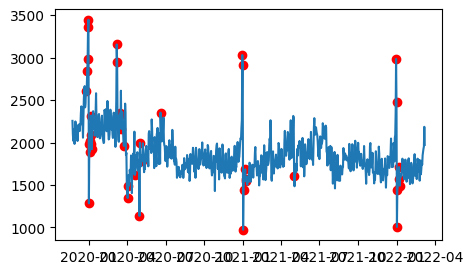

In [34]:
#Данные
dd = df.query('ou == @ou')
dd = dd.set_index('datetime')
dd = dd[[column]].resample('D').sum()
dd = dd[:-5]
dd['lag'] = dd[column].shift(periods=1)
dd['lag_7'] = dd[column].shift(periods=7)
dd.dropna(inplace=True)

#KNN
#Нужна ли нормализация ???
X = dd[['cheques',	'lag',	'lag_7']].values
knn = NearestNeighbors(n_neighbors=4)
knn.fit(X)

#Расчет расстояний (каждоя строка - расстояние до 1,2,3 соседа)
dist, idxs = knn.kneighbors(X)
#Среднее расстояние до соседей по каждой точке
dd['dist'] = dist.mean(axis=1)
threshold = percentile(dd.dist, 95)

#Разметка аномальных
dd['anomaly_knn'] = dd.dist > threshold

#Визуализация
a = dd.loc[dd['anomaly_knn'], [column]]
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(dd.index, dd[column])
ax.scatter(a.index, a[column], color='red')
plt.show()

**Isolation Forest** (один признак)

<Axes: xlabel='x', ylabel='cheques'>

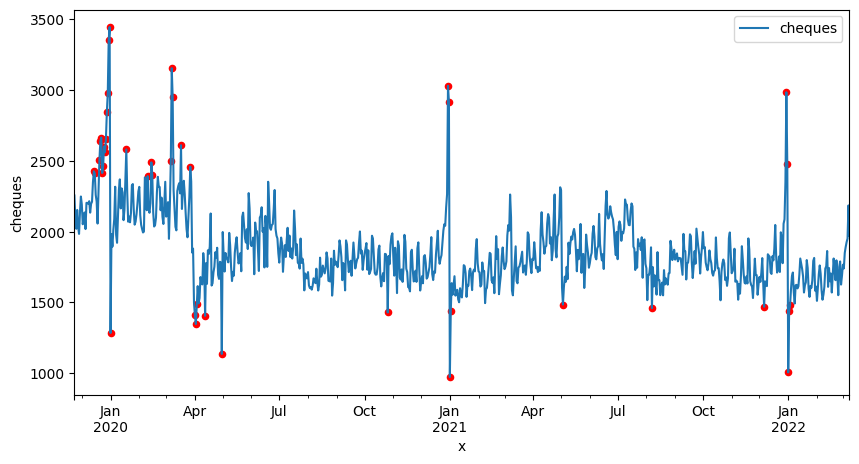

In [35]:
#Данные
dd = df.query('ou == @ou')
dd = dd.set_index('datetime')
dd = dd[[column]].resample('D').sum()
dd = dd[:-5]
dd['lag'] = dd[column].shift(periods=1)
dd['lag_7'] = dd[column].shift(periods=7)
dd.dropna(inplace=True)

#Нормализация
scaler = StandardScaler()
dd['scaled'] = scaler.fit_transform(dd[column].values.reshape(-1, 1))

#Обучение дерева решений
model = IsolationForest(contamination=0.05)
model.fit(dd[['scaled']])
dd['anomaly'] = model.predict(dd[['scaled']])

#Визуализация
fig, ax = plt.subplots(figsize=(10, 5))
a = dd.query('anomaly == -1')[[column]]
a['x'] = a.index
dd.plot(y = column, ax = ax)
a.plot(x = 'x', y = column, color='red', ax = ax, kind = 'scatter')
# plt.show()


**Предсказание**

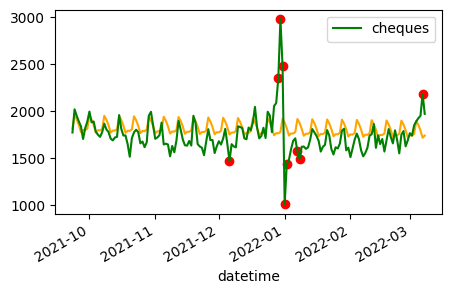

In [91]:
#Данные
dd = df.query('ou == @ou')
dd = dd.set_index('datetime')
dd = dd[[column]].resample('D').sum()
dd = dd[:-5]
dd['lag'] = dd[column].shift(periods=1)
dd['lag_7'] = dd[column].shift(periods=7)
dd.dropna(inplace=True)
X =dd[[column]].values

#Выборки
dd = dd.sort_index()
train_len = round(dd.shape[0]*0.8)
train = dd[:train_len]
test = dd[train_len:]

#Обучение
data = train[column]
ES = ExponentialSmoothing(data, seasonal_periods=7, trend='add', seasonal='add').fit()

#Предсказание
pred = ES.predict(train_len, dd.shape[0]-1).to_frame().reset_index()
pred.rename(columns={'index':'datetime', 0:'pred'}, inplace=True)
pred.set_index('datetime', inplace=True)
pred = pred.sort_index()

#Сравнение
pred['fact'] = test[column]
pred['MAPE'] = abs(pred.fact - pred.pred) / pred.fact
threshold = percentile(pred.MAPE, 95)
pred['anomaly'] = pred.MAPE > threshold

#Визуализация
fig, ax = plt.subplots(figsize=(5, 3))
a = pred.query('anomaly == True')[['fact']]
ax.plot(pred.index, pred.pred, color = 'orange')
ax.scatter(a.index, a.fact, color='red')
test[[column]].plot(ax = ax, color = 'green')
plt.show()

**Statistical anomalies**

/content/distribution_anomaly_detectors.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  else self.data[w] > self.mean
/content/distribution_anomaly_detectors.py:145: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  is_anomaly = self.data[w] < self.mean if self.lower \
/content/distribution_anomaly_detectors.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff = abs(self.data[w] - self.mean)
/content/distribution_anomaly_det

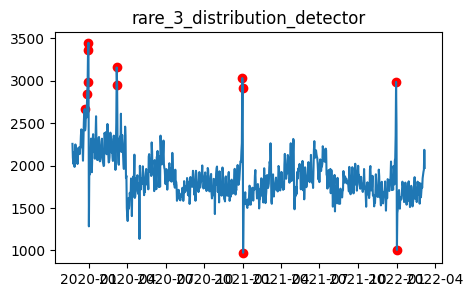

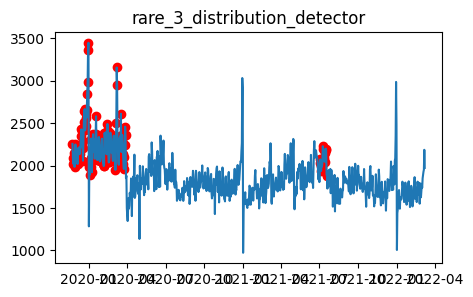

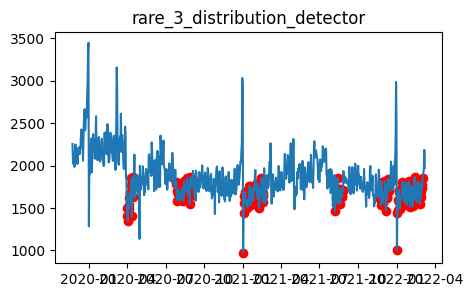

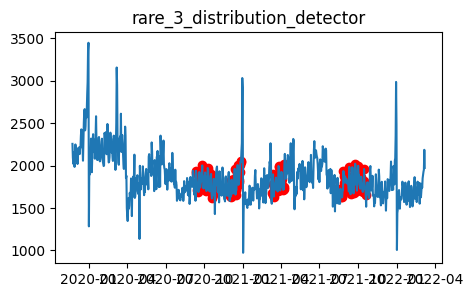

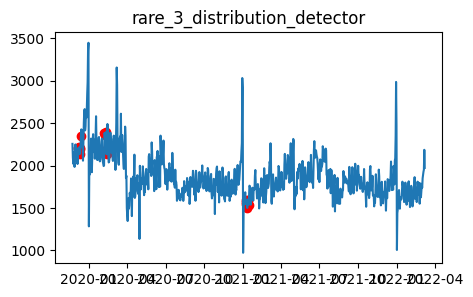

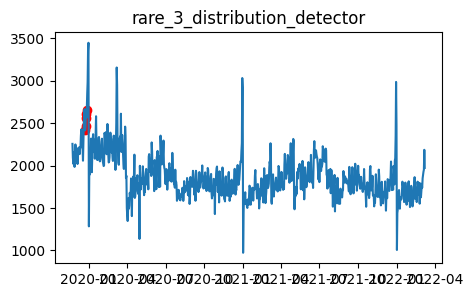

In [116]:
#Данные
dd = df.query('ou == @ou')
dd = dd.set_index('datetime')
dd = dd[[column]].resample('D').sum()
dd = dd[:-5]
dd['lag'] = dd[column].shift(periods=1)
dd['lag_7'] = dd[column].shift(periods=7)
dd.dropna(inplace=True)

#Определение детекторов
detectors = {
        'outlier_detector': OutlierDetector(dd[column]),
        'great_of_mean_detector': MeanAnomalyDetector(dd[column], lower=False, window=14),
        'least_of_mean_detector': MeanAnomalyDetector(dd[column], lower=True, window=14),
        'distribution_based_detector': DistributionBasedAnomalyDetector(dd[column]),
        'rare_1_distribution_detector': RareDistributionDetector(dd[column], n=1, window=25),
        'rare_2_distribution_detector': RareDistributionDetector(dd[column], n=2, window=7),
        'rare_3_distribution_detector': RareDistributionDetector(dd[column], n=3, window=3)}

#Применение детекторов
for detector_name, detector in detectors.items():
  result = detector.get_labels()
  if result.shape[0] > 0 :
    res = pd.DataFrame(result)
    res.columns = [detector_name]
    dd = dd.join(res, how = 'left')

#Визуализация
detect = [det for det in dd.columns if det in detectors.keys()]
for detector in detect:
  #Визуализация
  fig, ax = plt.subplots(figsize=(5, 3))
  a = dd[[detector, column]].dropna()
  ax.plot(dd[column])
  ax.scatter(a.index, a[column], c='red')
  plt.title(detector_name)
  plt.show()


**Многомерные ряды. PCA**

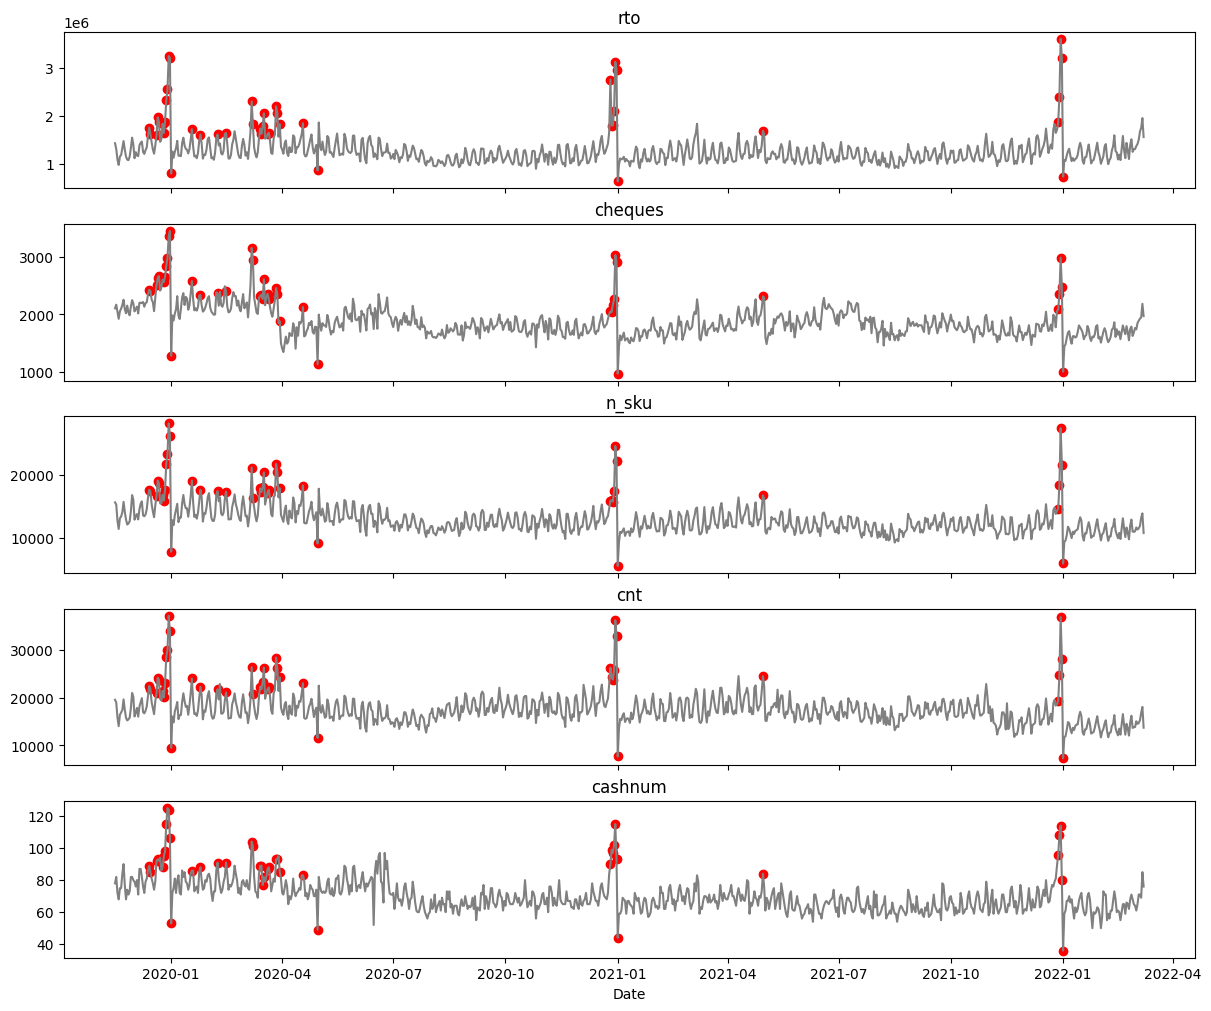

In [127]:
outliers_fraction = 0.05
random_state = 555
columns = ['rto', 'cheques', 'n_sku', 'cnt', 'cashnum']

#Данные
dd = df.query('ou == @ou')
dd = dd.set_index('datetime')
dd = dd[columns].resample('D').sum()
dd = dd[:-5]
dd.dropna(inplace=True)
X = dd.values

#Обучение
pca_detector = pyod_PCA(contamination=outliers_fraction, random_state=random_state)
pca_detector.fit(X)
pred = pca_detector.predict(X)
dd['anomaly'] = pred

#Визуализация
show_plots(dd, columns, 'anomaly')

**MCD**

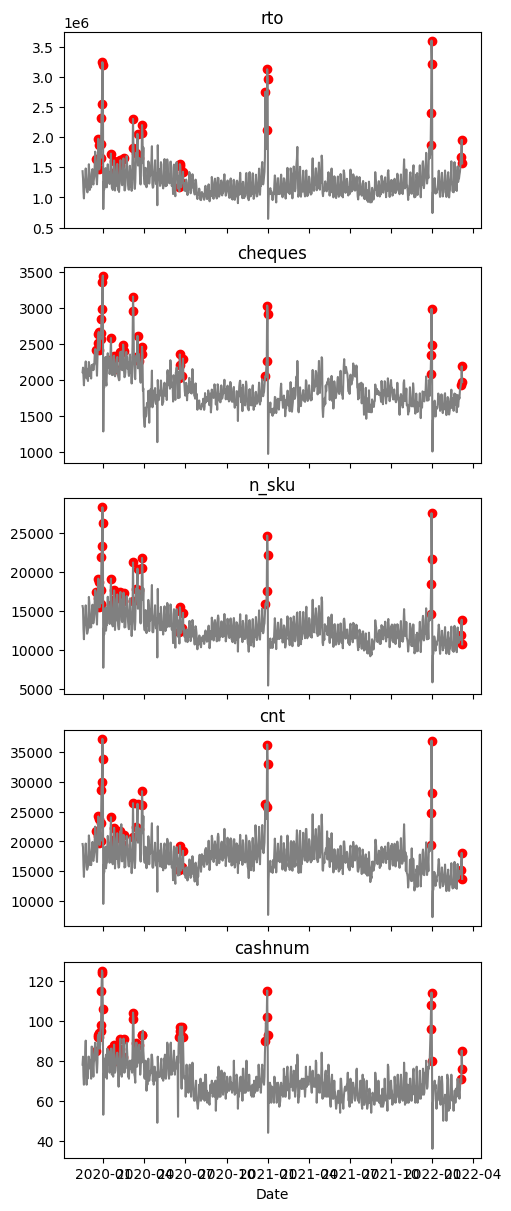

In [138]:
outliers_fraction = 0.05
random_state = 555
columns = ['rto', 'cheques', 'n_sku', 'cnt', 'cashnum']

#Данные
dd = df.query('ou == @ou')
dd = dd.set_index('datetime')
dd = dd[columns].resample('D').sum()
dd = dd[:-5]
dd.dropna(inplace=True)
X = dd.values

#Обучение
mcd_detector = pyod_MCD(contamination=outliers_fraction, random_state=random_state)
mcd_detector.fit(X)
pred = mcd_detector.predict(X)
dd['anomaly'] = pred

#Визуализация
show_plots(dd, columns, 'anomaly')

**ABOD**

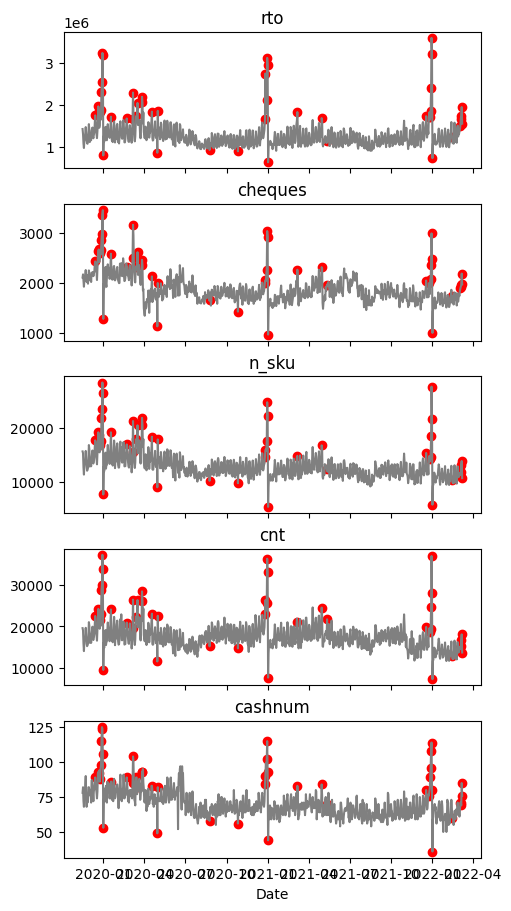

In [143]:
outliers_fraction = 0.05
random_state = 555
columns = ['rto', 'cheques', 'n_sku', 'cnt', 'cashnum']

#Данные
dd = df.query('ou == @ou')
dd = dd.set_index('datetime')
dd = dd[columns].resample('D').sum()
dd = dd[:-5]
dd.dropna(inplace=True)
X = dd.values

#Обучение
abod_detector = pyod_ABOD(contamination=outliers_fraction)
abod_detector.fit(X)
pred = abod_detector.predict(X)
dd['anomaly'] = pred

#Визуализация
show_plots(dd, columns, 'anomaly')

**HBOS**

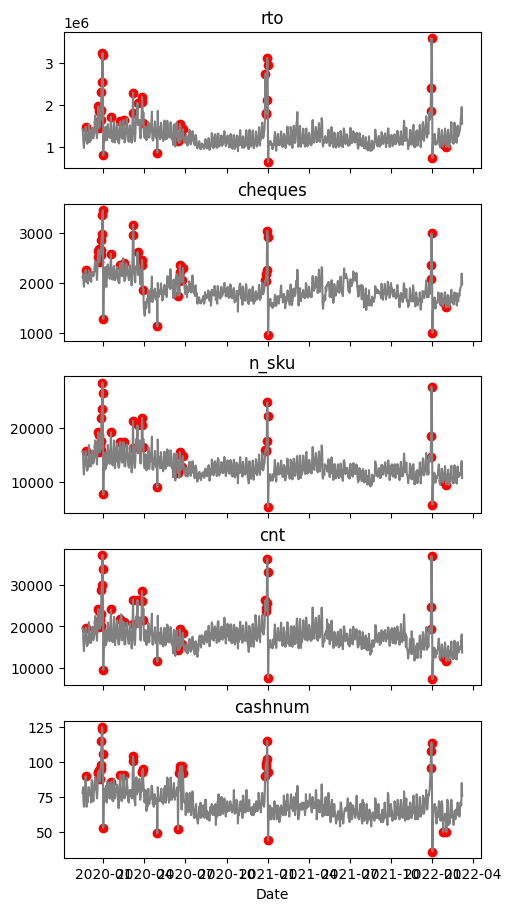

In [144]:
outliers_fraction = 0.05
random_state = 555
columns = ['rto', 'cheques', 'n_sku', 'cnt', 'cashnum']

#Данные
dd = df.query('ou == @ou')
dd = dd.set_index('datetime')
dd = dd[columns].resample('D').sum()
dd = dd[:-5]
dd.dropna(inplace=True)
X = dd.values

#Обучение
hbos_detector = pyod_HBOS(contamination=outliers_fraction)
hbos_detector.fit(X)
pred = hbos_detector.predict(X)
dd['anomaly'] = pred

#Визуализация
show_plots(dd, columns, 'anomaly')

**IForest**



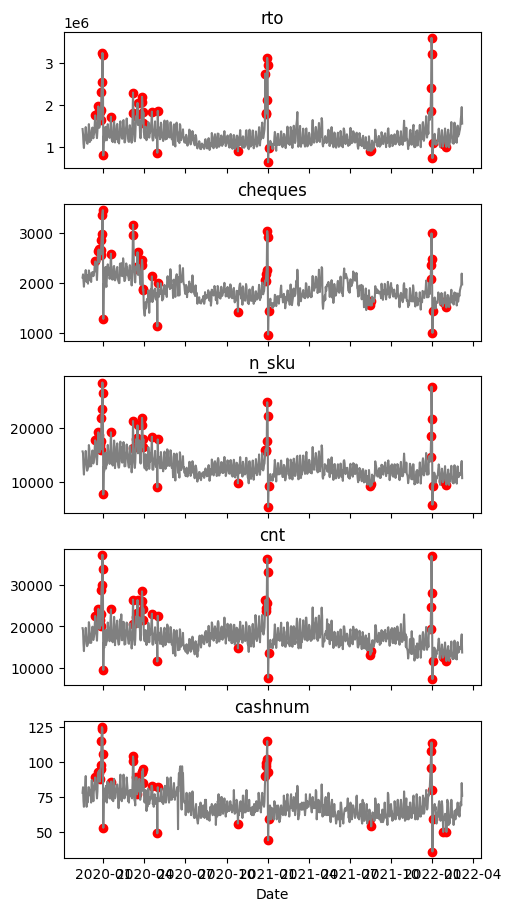

In [147]:
outliers_fraction = 0.05
random_state = 555
columns = ['rto', 'cheques', 'n_sku', 'cnt', 'cashnum']

#Данные
dd = df.query('ou == @ou')
dd = dd.set_index('datetime')
dd = dd[columns].resample('D').sum()
dd = dd[:-5]
dd.dropna(inplace=True)
X = dd.values

#Обучение
if_detector = pyod_IF(contamination=outliers_fraction, random_state = random_state)
if_detector.fit(X)
pred = if_detector.predict(X)
dd['anomaly'] = pred

#Визуализация
show_plots(dd, columns, 'anomaly')

**KNN**

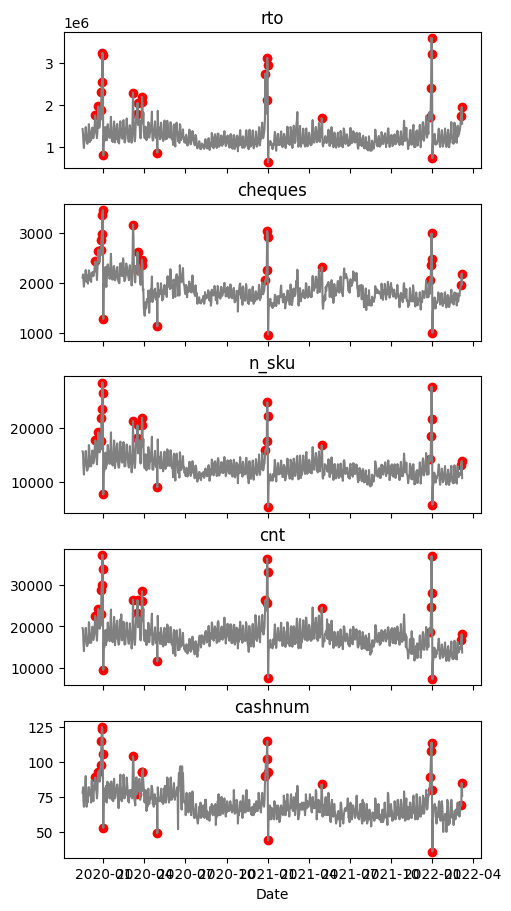

In [148]:
outliers_fraction = 0.05
random_state = 555
columns = ['rto', 'cheques', 'n_sku', 'cnt', 'cashnum']

#Данные
dd = df.query('ou == @ou')
dd = dd.set_index('datetime')
dd = dd[columns].resample('D').sum()
dd = dd[:-5]
dd.dropna(inplace=True)
X = dd.values

#Обучение
knn_detector = pyod_KNN(contamination=outliers_fraction, method='mean')
knn_detector.fit(X)
pred = knn_detector.predict(X)
dd['anomaly'] = pred

#Визуализация
show_plots(dd, columns, 'anomaly')

**LOF**

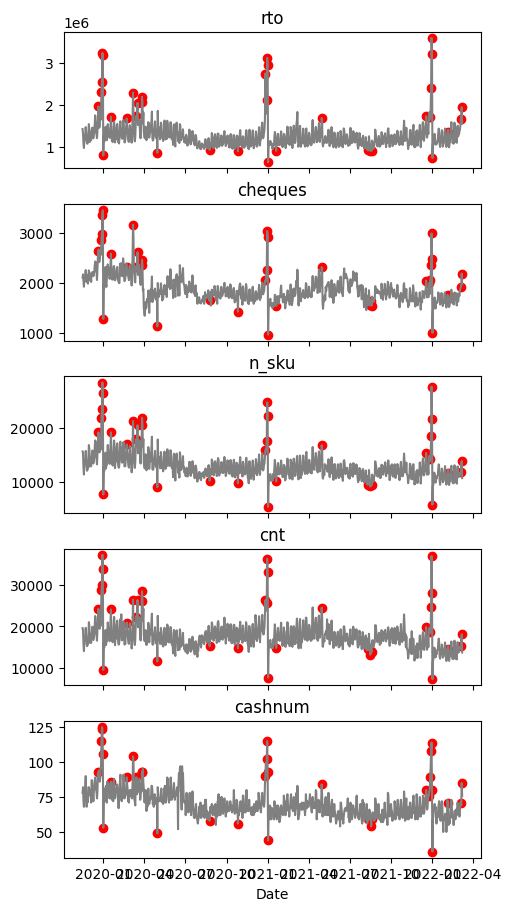

In [8]:
outliers_fraction = 0.05
random_state = 555
columns = ['rto', 'cheques', 'n_sku', 'cnt', 'cashnum']

#Данные
dd = df.query('ou == @ou')
dd = dd.set_index('datetime')
dd = dd[columns].resample('D').sum()
dd = dd[:-5]
dd.dropna(inplace=True)
X = dd.values

#Обучение
lof_detector = pyod_LOF(n_neighbors=20, contamination=outliers_fraction)
lof_detector.fit(X)
pred = lof_detector.predict(X)
dd['anomaly'] = pred

#Визуализация
show_plots(dd, columns, 'anomaly')

cblof_detector = CBLOF(contamination=outliers_fraction, random_state=random_state)

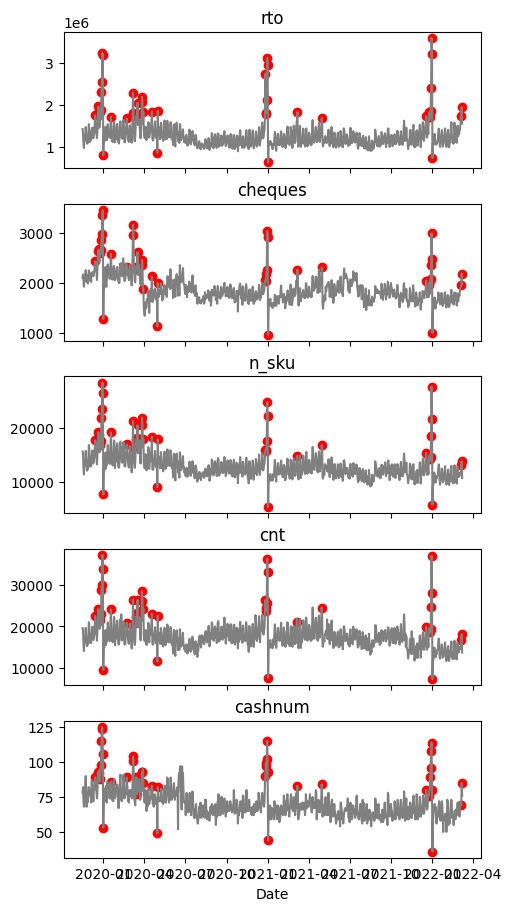

In [9]:
outliers_fraction = 0.05
random_state = 555
columns = ['rto', 'cheques', 'n_sku', 'cnt', 'cashnum']

#Данные
dd = df.query('ou == @ou')
dd = dd.set_index('datetime')
dd = dd[columns].resample('D').sum()
dd = dd[:-5]
dd.dropna(inplace=True)
X = dd.values

#Обучение
cblof_detector = pyod_CBLOF(contamination=outliers_fraction, random_state=random_state)
cblof_detector.fit(X)
pred = cblof_detector.predict(X)
dd['anomaly'] = pred

#Визуализация
show_plots(dd, columns, 'anomaly')

**LSCP**

/usr/local/lib/python3.10/dist-packages/pyod/models/lscp.py:380: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(


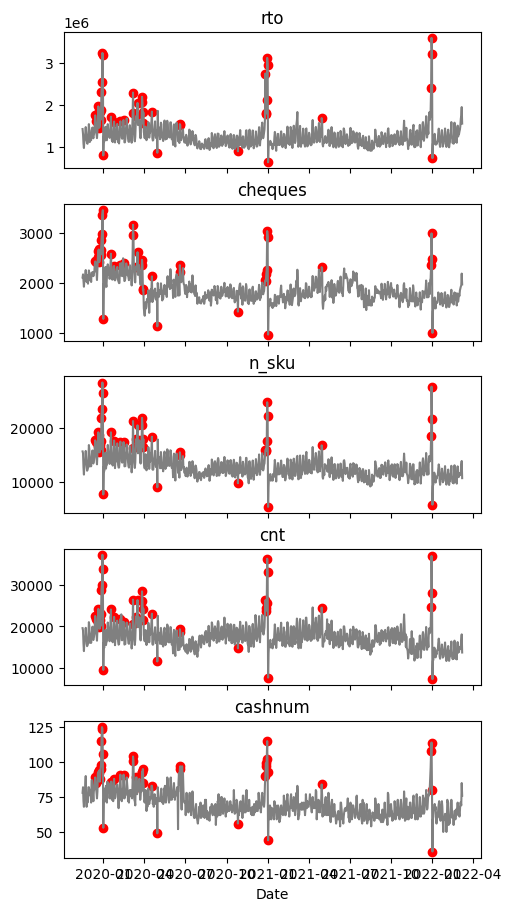

In [11]:
outliers_fraction = 0.05
random_state = 555
columns = ['rto', 'cheques', 'n_sku', 'cnt', 'cashnum']

#Данные
dd = df.query('ou == @ou')
dd = dd.set_index('datetime')
dd = dd[columns].resample('D').sum()
dd = dd[:-5]
dd.dropna(inplace=True)
X = dd.values


#Обучение
detector_list = [
    pyod_PCA(contamination=outliers_fraction, random_state=random_state),
    pyod_HBOS(contamination=outliers_fraction),
    pyod_LOF(contamination=outliers_fraction),
    pyod_ABOD(contamination=outliers_fraction),
    pyod_IF(contamination=outliers_fraction, random_state=random_state)
]

lscp_detector = pyod_LSCP(detector_list, contamination=outliers_fraction, \
                          random_state=random_state)

lscp_detector.fit(X)
pred = lscp_detector.predict(X)
dd['anomaly'] = pred

#Визуализация
show_plots(dd, columns, 'anomaly')